In [2]:
#import OS to share the project dir
import os
os.chdir('F:\\fourth_year\Pattern_Classification\project\Writer_Identification') 

#import important packages
from IAM_loader import IAM_loader
#import tensorflow as tf
#import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import cv2 as cv2
from PIL import Image
import math
from skimage import feature
from operator import itemgetter
from scipy import stats
from sklearn.metrics import mean_squared_error
from skimage.feature import peak_local_max
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
#packages for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#allows charts to appear in the notebook 
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Reading Data :

In [3]:
# we use IAM handwriting database download it first
# here we will read the images and get the important info about the images 
# we divide the available images into (train,cv and test)
# division will be depend on the number of the images 

training_data=[] # only the train 
training_data_threshold=[] #training black images 
test_data_threshold=[] #test black images 
validation_data=[] # cross validation 
test_data=[] # test images 

WIDTH=2175 #image width
HEIGHT=2304 #image height
path="../dataset/output2"


In [4]:
def reading_and_preprocess():
    loader=IAM_loader('../dataset')
    training_data,test_data,validation_data = loader.split_data()
    #writting the data 
    training_data_threshold=training_data
    test_data_threshold=validation_data
    
    #getting the thresholded images of the training
    for i in range(len(training_data)):
            temp=training_data[i][0]
            _,image= cv2.threshold(temp,0,255,cv2.THRESH_BINARY_INV)
            training_data_threshold[i][0]=image
            
    #getting the thresholded images of the test
    for i in range(len(validation_data)):
            temp=validation_data[i][0]
            _,image= cv2.threshold(temp,0,255,cv2.THRESH_BINARY_INV)
            test_data_threshold[i][0]=image
    return training_data,test_data,validation_data,training_data_threshold,test_data_threshold

In [5]:
#get the window that contains the words 
def crop_image(image,y1,y2,x1,x2):
    image=image[y1:y2,x1:x2]
    return image

In [6]:
#note : use WIDTH and HEIGHT 
def resize_image (img):
    img=cv2.resize(img, dsize=(HEIGHT, WIDTH), interpolation=cv2.INTER_CUBIC)
    return img

In [7]:
def detect_lines(img):
    horizontal_lines=[]
    ret_lines=[] 
    #apply canny 
    edges = cv2.Canny(img,50,150,apertureSize = 3)
    #dilation
    kernel = np.ones((5,5), np.uint8)
    img_dilation = cv2.dilate(edges, kernel, iterations=1)
    #hough line transform
    lines = cv2.HoughLinesP(img_dilation, 1, np.pi/180,200, maxLineGap=1,minLineLength=img.shape[1]/2)
    #getting the horizontal lines 
    for i in range(len(lines)):
           for line in lines[i]:
                pt1 = (line[0],line[1])
                pt2 = (line[2],line[3])
                if (line[1]-line[3])==0 : #print((line[2]-line[3])//(line[0]-line[1]))
                        cv2.line(img, pt1, pt2, (255,255,255), 3) 
                        horizontal_lines.append(line)
    #sort lines to eleminate the closed lines 
    horizontal_lines=sorted(horizontal_lines,key=lambda x: x[1])
    pt=horizontal_lines[0]
    ret_lines.append(pt)
    #loop to retrive the included lines 
    for i in range(1,len(horizontal_lines)):
        if abs(horizontal_lines[i][1]-pt[1])>100:
            #print("included",horizontal_lines[i])
            pt=horizontal_lines[i]
            ret_lines.append(pt)
    return ret_lines

In [8]:
def get_region():
    for i in range(len(training_data)):
        img=training_data[i][0]
        lines=detect_lines(img)
        print(len(lines))
        print(img.shape,lines[1][1]+10,lines[2][1]-3,math.floor(lines[1][0]/4),img.shape[1]-1)
        cropped_img=crop_image(img,lines[1][1]+10,lines[2][1]-3,math.floor(lines[1][0]/4),img.shape[1]-1)
        cropped_img=resize_image(cropped_img)
        training_data[i][0]=cropped_img


In [64]:
def get_histogram(img):
    histogram=[]
    #loop through the image to calcultae the  horizontal histogram of the image
    for i in range(img.shape[0]): #for each row
        sum=0
        for j in range(img.shape[1]): # for each col
            if img[i][j]==0:
                sum+=1
        histogram.append(sum)
    print(len(histogram),img.shape)
    return histogram

In [61]:
def draw_image_histogram(hist, width,color='k'):
    plt.plot(hist, color=color)
    plt.xlim([0, width])

In [10]:
def get_local_min(hist):
    hist=np.array(hist)
    local_minima=argrelextrema(hist, np.less)
    return local_minima

In [40]:
def get_lines(img,hist,index):
    prev_y=0
    num=0
    lines=[]
    line_num=0
    for i in range(len(hist)):
        if ((i-prev_y)>0 and (num/(i-prev_y))>0.25 and hist[i]==0 and hist[i-1]!=hist[i] and i-prev_y>100) or ((i-prev_y)>0 and (num/(i-prev_y))>0.25 and hist[i]<20 and hist[i-1]<20 and hist[i-1]!=hist[i] and i-prev_y>100) :
            temp=img[prev_y:i+5,0:img.shape[1]]
            prev_y=i+5
            num=0
            #cv2.imwrite("../dataset/hager/line"+str(index)+str(line_num)+".png",temp)
            line_num+=1
            lines.append(temp)
        elif hist[i]>30:
            num+=1
        
    return lines

In [41]:
 def line_segmentation(img,num):
    im = cv2.erode(img,np.ones((3,200), np.uint8))
    im = cv2.medianBlur(im,5)
    im = cv2.bitwise_not(im)
    w= np.size(img,1)
    # cv2.imshow("i",cv2.resize(im,(700,500)))
    # cv2.waitKey(0)

    lines = []
    _,cnt,_ = cv2.findContours(im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    for contour in cnt:
        x=[c[0] for c in contour.reshape(-1,2)]
        y=[c[1] for c in contour.reshape(-1,2)]
        minx,miny,maxx,maxy=np.min(x),np.min(y),np.max(x),np.max(y)
        if (maxx-minx)>=(0.8*w):
            cv2.imwrite("../dataset/reem/line"+str(num)+str(i)+".png",img[miny:maxy,minx:maxx])
            lines.append(img[miny:maxy,minx:maxx])
            i+=1
    return lines

In [13]:
training_data,test_data,validation_data,training_data_threshold,test_data_threshold=reading_and_preprocess()

Adding document a01-000u to the training data
Adding document a01-003u to the training data
Adding document a01-007u to the training data
Adding document a01-011u to the training data
Adding document a01-014u to the training data
Adding document a01-020u to the training data
Adding document a01-026u to the training data
Adding document a01-030u to the training data
Adding document a01-043u to the training data
Adding document a01-049u to the training data
Adding document a01-049x to the training data
Adding document a01-053u to the training data
Adding document a01-058u to the training data
Adding document a01-063u to the training data
Adding document a01-068u to the training data
Adding document a01-072u to the training data
Adding document a01-077u to the training data
Adding document a01-082u to the training data
Adding document a01-087u to the training data
Adding document a01-091u to the training data
Adding document a01-096u to the training data
Adding document a01-102u to the tr

In [14]:
get_region()

3
(3542, 2479) 614 2786 217 2478
3
(3542, 2479) 716 2788 179 2478
3
(3542, 2479) 664 2786 183 2478
3
(3542, 2479) 663 2785 208 2478
3
(3542, 2479) 664 2786 198 2478
3
(3542, 2479) 666 2787 165 2478
3
(3542, 2479) 714 2787 220 2478
3
(3542, 2479) 714 2786 171 2478
3
(3542, 2479) 663 2785 177 2478
3
(3542, 2479) 711 2784 211 2478
3
(3542, 2479) 734 2804 81 2478
3
(3542, 2479) 711 2784 185 2478
3
(3542, 2479) 662 2785 221 2478
3
(3542, 2479) 664 2787 196 2478
3
(3542, 2479) 662 2785 198 2478
3
(3542, 2479) 663 2786 185 2478
3
(3542, 2479) 661 2785 229 2478
3
(3542, 2479) 763 2787 172 2478
3
(3542, 2479) 662 2785 187 2478
3
(3542, 2479) 663 2786 225 2478
3
(3542, 2479) 713 2787 198 2478
3
(3542, 2479) 664 2787 208 2478
3
(3542, 2479) 613 2786 225 2478
3
(3542, 2479) 715 2789 85 2478
3
(3542, 2479) 711 2786 223 2478
3
(3542, 2479) 662 2786 225 2478
3
(3542, 2479) 713 2787 169 2478
3
(3542, 2479) 662 2785 206 2478
3
(3542, 2479) 688 2805 80 2478
3
(3542, 2479) 635 2803 81 2478
3
(3542, 2479)

IndexError: list index out of range

In [39]:
for i in range(55):
    img=training_data[i][0]
    #convert to gray scale
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #getting the binary image
    ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    #calculate the histogram
    hist=get_histogram(img)
    local_min=get_local_min(hist)
    local_min=local_min[0].ravel()
    get_lines(img,hist,i)
    _=line_segmentation(img,i)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [65]:
img=training_data[0][0]
#convert to gray scale
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#getting the binary image
ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
#calculate the histogram
hist=get_histogram(img)
lines=get_lines(img,hist,i)
line_hist=get_histogram(lines[0])

2175 (2175, 2304)
217 (217, 2304)


217 (217, 2304)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 7, 8, 8, 8, 24, 34, 37, 43, 47, 52, 53, 56, 67, 73, 85, 93, 95, 102, 105, 105, 107, 122, 132, 146, 164, 174, 180, 196, 190, 212, 224, 239, 248, 270, 278, 297, 318, 359, 425, 472, 495, 517, 517, 524, 523, 511, 487, 470, 475, 473, 475, 471, 480, 506, 506, 501, 502, 488, 518, 516, 470, 478, 484, 444, 386, 315, 247, 200, 131, 85, 59, 52, 34, 19, 19, 19, 20, 19, 20, 18, 17, 15, 12, 8, 9]


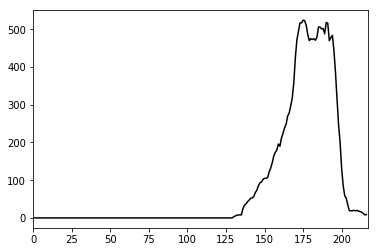

In [66]:
print(len(line_hist),lines[0].shape)
print(line_hist)
draw_image_histogram(line_hist,lines[0].shape[0])